# Movie Rating Prediction using Random Forest Regression
In this notebook, we will build a machine learning model to predict movie ratings based on various features such as genres, themes, actors, directors, and descriptions. I will use a Random Forest Regressor for this task.

The dataset includes multiple CSV files:

- movies.csv
- actors.csv
- genres.csv
- themes.csv
- crew.csv

I will preprocess the data, merge the datasets, extract features using TF-IDF vectorization, and evaluate the model's performance.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
)
from scipy.sparse import hstack, csr_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### Load Data

In [2]:
def load_data():
    movies = pd.read_csv('movie_dataset/movies.csv')
    actors = pd.read_csv('movie_dataset/actors.csv')
    genres = pd.read_csv('movie_dataset/genres.csv')
    themes = pd.read_csv('movie_dataset/themes.csv')
    crew = pd.read_csv('movie_dataset/crew.csv')
    return movies, actors, genres, themes, crew

movies_df, actors_df, genres_df, themes_df, crew_df = load_data()


### Data Preprocessing

In [3]:
def merge_datasets(movies, actors, genres, themes, crew):
    genres_grouped = genres.groupby('id')['genre'].apply(lambda x: ' '.join(x)).reset_index()
    movies = movies.merge(genres_grouped, on='id', how='left')

    themes_grouped = themes.groupby('id')['theme'].apply(lambda x: ' '.join(x)).reset_index()
    movies = movies.merge(themes_grouped, on='id', how='left')

    actors_grouped = actors.groupby('id')['name'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
    movies = movies.merge(actors_grouped, on='id', how='left')

    directors = crew[crew['role'] == 'Director']
    crew_grouped = directors.groupby('id')['name'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
    crew_grouped.rename(columns={'name': 'director'}, inplace=True)
    movies = movies.merge(crew_grouped, on='id', how='left')

    movies.rename(columns={'name_x': 'name', 'name_y': 'actors'}, inplace=True)
    
    numeric_columns = movies.select_dtypes(include=['float64', 'int64']).columns
    string_columns = movies.select_dtypes(include=['object']).columns

    movies = movies.dropna(subset=['rating'])
    movies[numeric_columns] = movies[numeric_columns].fillna(0)
    movies[string_columns] = movies[string_columns].fillna('')

    return movies

movies_df = merge_datasets(movies_df, actors_df, genres_df, themes_df, crew_df)



Rating Statistics:
------------------------------
Mean Rating:    3.24
Median Rating:  3.30
Std Deviation:  0.42
Min Rating:     0.88
Max Rating:     4.69


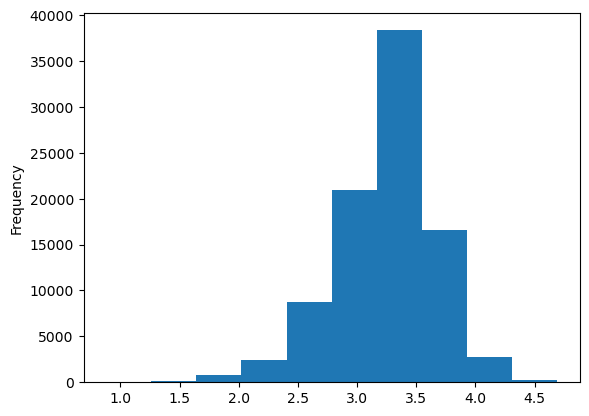

In [12]:
def prepare_features(movies_df):
    print("\nRating Statistics:")
    print("-" * 30)
    print(f"Mean Rating:    {movies_df['rating'].mean():.2f}")
    print(f"Median Rating:  {movies_df['rating'].median():.2f}")
    print(f"Std Deviation:  {movies_df['rating'].std():.2f}")
    print(f"Min Rating:     {movies_df['rating'].min():.2f}")
    print(f"Max Rating:     {movies_df['rating'].max():.2f}")
    
    movies_df["rating"].plot(kind="hist")
    plt.show()


    tfidf = TfidfVectorizer(
        max_features=500,
        stop_words='english',
        min_df=2,
        max_df=0.9,
        ngram_range=(1, 3)
    )
    
    genre_features = tfidf.fit_transform(movies_df['genre'].astype(str))
    theme_features = tfidf.fit_transform(movies_df['theme'].astype(str))
    actor_features = tfidf.fit_transform(movies_df['actors'].astype(str))
    director_features = tfidf.fit_transform(movies_df['director'].astype(str))
    description_features = tfidf.fit_transform(movies_df['description'].astype(str))
    
    numerical_features = np.column_stack([
        movies_df[['date', 'minute']].values,
        movies_df['minute'].apply(lambda x: x / 30).values.reshape(-1, 1),  # Normalized duration
    ])
    
    scaler = StandardScaler()
    numerical_features_scaled = scaler.fit_transform(numerical_features)
    
    # Combine all features
    X = hstack([
        csr_matrix(numerical_features_scaled),
        genre_features,
        theme_features,
        actor_features,
        director_features,
        description_features
    ])
    y = movies_df['rating']
    
    return train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Prepare features and split data
X_train, X_test, y_train, y_test = prepare_features(movies_df)


### Random Forest Model Setup and Evaluation

In this section, I initialize a `RandomForestRegressor` to predict movie ratings. I chose the following hyperparameters for the model:

- **n_estimators=500**: This sets the number of trees in the forest. A higher number generally improves performance but increases computation time.
- **max_depth=25**: Limiting the depth of each tree helps prevent overfitting, ensuring the model generalizes well to unseen data.
- **min_samples_split=5**: This parameter specifies the minimum number of samples required to split an internal node. It helps control overfitting by requiring a certain number of samples before making a split.
- **min_samples_leaf=2**: This sets the minimum number of samples that must be present in a leaf node, further preventing overfitting.
- **max_features='sqrt'**: This means that the model will consider a random subset of features for each split, which helps in reducing correlation among trees and improving model robustness.
- **bootstrap=True**: This enables bootstrapping, allowing the model to sample with replacement, which is essential for creating diverse trees in the ensemble.
- **n_jobs=-1**: This allows the model to use all available CPU cores for training, speeding up the process.
- **random_state=42**: Setting a random state ensures reproducibility of results.

After setting up the model, I perform cross-validation using `cross_val_score` with 5 folds to evaluate its performance. This provides a more reliable estimate of the model's effectiveness by testing it on different subsets of the data. Finally, I fit the model to the training data to prepare it for making predictions.

In [5]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

rf_model.fit(X_train, y_train)



Cross-validation scores: [0.33507678 0.33411513 0.32978622 0.33000547 0.33270697]
Average CV score: 0.33233811476608255


RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [6]:
# Make predictions
y_pred = rf_model.predict(X_test)

y_pred = np.clip(y_pred, 1, 5)

# Calculate and print evaluation metrics
print("\nModel Performance Metrics:")
print("-" * 30)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


Model Performance Metrics:
------------------------------
Mean Squared Error: 0.1153
Root Mean Squared Error: 0.3395
Mean Absolute Error: 0.2531
R² Score: 0.3411

Top 10 Most Important Features:
------------------------------
Feature 313: 0.0429
Feature 165: 0.0377
Feature   0: 0.0351
Feature   1: 0.0351
Feature   2: 0.0342
Feature 176: 0.0230
Feature   3: 0.0173
Feature 435: 0.0128
Feature  97: 0.0106
Feature 736: 0.0077


### confusion matrix heatmap of the results


Prediction Accuracy:
------------------------------
✓ Within 0.5 stars: 87.0%
✓ Within 1.0 stars: 98.8%


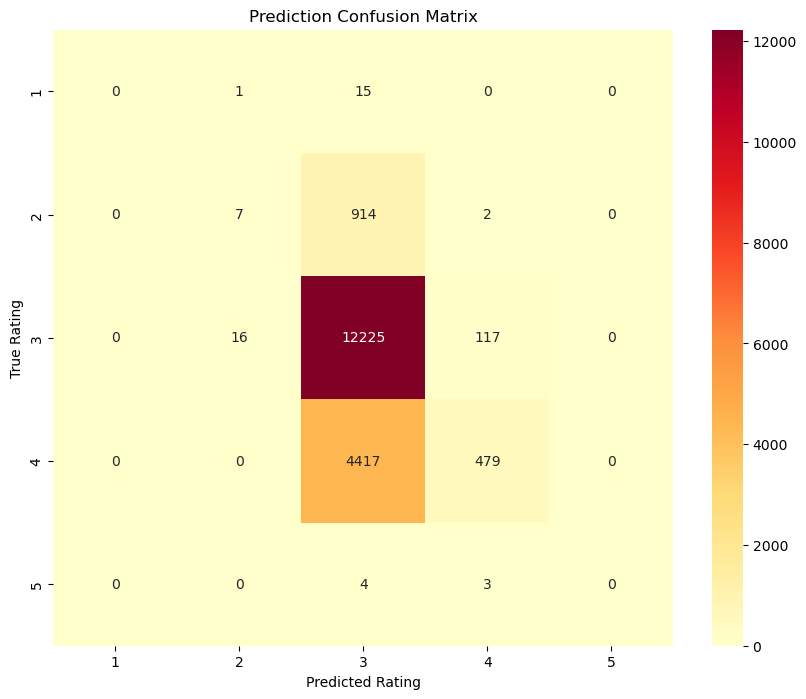

In [7]:
def evaluate_predictions(y_true, y_pred):
    # Calculate metrics
    within_half_star = np.mean(abs(y_true - y_pred) <= 0.5) * 100
    within_one_star = np.mean(abs(y_true - y_pred) <= 1.0) * 100
    
    print("\nPrediction Accuracy:")
    print("-" * 30)
    print(f"✓ Within 0.5 stars: {within_half_star:.1f}%")
    print(f"✓ Within 1.0 stars: {within_one_star:.1f}%")
    
    y_pred_rounded = np.round(y_pred)
    y_true_rounded = np.round(y_true)
    cm = confusion_matrix(y_true_rounded, y_pred_rounded, labels=range(1, 6))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=range(1, 6),
                yticklabels=range(1, 6))
    plt.title('Prediction Confusion Matrix')
    plt.xlabel('Predicted Rating')
    plt.ylabel('True Rating')
    plt.show()

# Evaluate predictions
evaluate_predictions(y_test, y_pred)


### Conclusion

Looking at our model's performance metrics, we can see that our Random Forest Regressor did an okay job, but there's definitely room for improvement. The RMSE of 0.34 and MAE of 0.25 tell us that on average, we're off by about a quarter to third of a star in our predictions. The R² score of 0.34 isn't great - it means we're only explaining about 34% of the variance in movie ratings.

In my opinion:
 The biggest problem is that even though we have a massive dataset of around 1 million movies, only a small fraction actually has ratings. Plus, as we can see in the histogram, the ratings follow a pretty strong normal distribution (bell curve), which creates a bias towards the middle ratings. This makes it harder for our model to predict the extreme ratings (very good or very bad movies).

I chose Random Forest for this project because:
- It's great at handling messy data and outliers
- Can deal with both numerical stuff (like movie length) and text data (like descriptions)
- Doesn't overfit as easily as single decision trees
- Works well even when features are correlated (like genres often are)

### How I could make it better

A few ideas to boost performance:

1. **Better Feature Engineering**
   - Add sentiment analysis on movie descriptions
   - Create interaction features between genres
   - Extract more info from release dates (like seasons/holidays)

2. **Play with the Model**
   - Try different hyperparameters (maybe use GridSearchCV)
   - Test other algorithms like XGBoost or LightGBM
   - Combine multiple models together

3. **More Data**
   - Get user reviews if possible
   - Add box office numbers
   - Include budget information
   - Get more movies in the dataset

4. **Clean Up the Data**
   - Handle missing values better
   - Maybe remove outliers
   - Balance out the rating distribution

The current results aren't terrible, but with some additional improvements, I could probably get  better at predicting movie ratings. The hardest part is that movie ratings are pretty subjective - even humans often disagree on them!